In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("farjanakabirsamanta/skin-cancer-dataset")

print("Path to dataset files:", path)

100%|██████████| 2.58G/2.58G [00:24<00:00, 113MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/farjanakabirsamanta/skin-cancer-dataset/versions/1


In [2]:
import os
import cv2
import shutil
import random
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.utils import to_categorical
from tensorflow.keras import Sequential
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization

import warnings
warnings.filterwarnings("ignore")

In [3]:
df= pd.read_csv(f"{path}/HAM10000_metadata.csv")
df.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [4]:
print("Unique Cancer types represented in data.")
print(df.dx.unique(),"\n")

encoder = LabelEncoder()
df["dx_label"] = encoder.fit_transform(df["dx"])

print("Cancer types and their integer encoding")
print(encoder.classes_)
print(encoder.transform(encoder.classes_))

Unique Cancer types represented in data.
['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec'] 

Cancer types and their integer encoding
['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']
[0 1 2 3 4 5 6]


In [5]:
df.head()

lesion_id      image_id   dx dx_type   age   sex localization  dx_label
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp         2
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp         2
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp         2
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp         2
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear         2

Data sorting, visualization & augmentation


In [ ]:

dir_names = encoder.transform(encoder.classes_)

images_dir = os.path.join(path, "Skin Cancer/Skin Cancer")  
train_images_dir = "/content/train/" 

def create_dirs(dir_path: str, dir_names: list):

    for dir_name in dir_names:
        try:
            os.makedirs(os.path.join(dir_path, str(dir_name)))
            print(f"Created directory: {os.path.join(dir_path, str(dir_name))}")
        except FileExistsError:
            continue

print(f"Creating training directory structure at: {train_images_dir}")
create_dirs(train_images_dir, dir_names)

if not os.path.exists(images_dir):
    raise FileNotFoundError(f"Source image directory not found at: {images_dir}")


total_images = 0
copied_images = 0

for _ in os.scandir(images_dir):
    total_images += 1

print(f"\nStarting to sort {total_images} images...")

for image in os.scandir(images_dir):
    try:
        img_name = image.name.split(".")[0]
        img_cancer_type = str(df.dx_label[df.image_id == img_name].item())
        dest_path = os.path.join(train_images_dir, img_cancer_type, image.name)
        shutil.copy(os.path.join(images_dir, image.name), dest_path)
        copied_images += 1

        if copied_images % 500 == 0:
            print(f"Processed {copied_images}/{total_images} images...")
    except Exception as e:
        print(f"Error processing {image.name}: {str(e)}")

print(f"\nFinished! Successfully sorted {copied_images}/{total_images} images")
print(f"Images organized in: {train_images_dir}")


print("\nVerification - Number of images per class:")
for class_dir in sorted(os.listdir(train_images_dir)):
    class_path = os.path.join(train_images_dir, class_dir)
    print(f"Class {class_dir}: {len(os.listdir(class_path))} images")

Creating training directory structure at: /content/train/
Created directory: /content/train/0
Created directory: /content/train/1
Created directory: /content/train/2
Created directory: /content/train/3
Created directory: /content/train/4
Created directory: /content/train/5
Created directory: /content/train/6

Starting to sort 10015 images...
Processed 500/10015 images...
Processed 1000/10015 images...
Processed 1500/10015 images...
Processed 2000/10015 images...
Processed 2500/10015 images...
Processed 3000/10015 images...
Processed 3500/10015 images...
Processed 4000/10015 images...
Processed 4500/10015 images...
Processed 5000/10015 images...
Processed 5500/10015 images...
Processed 6000/10015 images...
Processed 6500/10015 images...
Processed 7000/10015 images...
Processed 7500/10015 images...
Processed 8000/10015 images...
Processed 8500/10015 images...
Processed 9000/10015 images...
Processed 9500/10015 images...
Processed 10000/10015 images...

Finished! Successfully sorted 10015

In [7]:
validation_images_dir = "/content/validation/"
inds = []
five_percent_content = {}

if not os.path.exists(train_images_dir):
    raise FileNotFoundError(f"Training directory not found at: {train_images_dir}")

print("Calculating image counts per class...")

for dir_name in os.scandir(train_images_dir):
    if dir_name.is_dir():
        class_count = 0
        for _ in os.scandir(dir_name):
            class_count += 1
            inds.append(dir_name.name)  #

        c_type = encoder.inverse_transform([int(dir_name.name)])[0]
        five_percent = max(1, round(class_count * 0.05))  # Ensure at least 1 image
        five_percent_content[dir_name.name] = five_percent

        print(f"Class {dir_name.name} ({c_type}): {class_count} images")
        print(f"Will move {five_percent} images to validation set\n")

print(f"\nCreating validation directory at: {validation_images_dir}")
create_dirs(validation_images_dir, dir_names)

total_moved = 0

# Moving 5% of each type to validation folder
print("\nMoving images to validation set...")
for sub_dir in os.scandir(train_images_dir):
    if sub_dir.is_dir():

        images_paths = [image.path for image in os.scandir(sub_dir)]
        num_to_move = five_percent_content[sub_dir.name]

        print(f"Moving {num_to_move} images from class {sub_dir.name}...")

        # Move the first n images
        for image_path in images_paths[:num_to_move]:
            dest_path = os.path.join(validation_images_dir,
                                   sub_dir.name,
                                   os.path.basename(image_path))
            shutil.move(image_path, dest_path)
            total_moved += 1

print(f"\nCompleted! Moved {total_moved} images to validation set")
print("Validation set distribution:")
for class_dir in os.listdir(validation_images_dir):
    class_path = os.path.join(validation_images_dir, class_dir)
    print(f"Class {class_dir}: {len(os.listdir(class_path))} images")



Calculating image counts per class...
Class 4 (mel): 1113 images
Will move 56 images to validation set

Class 3 (df): 115 images
Will move 6 images to validation set

Class 2 (bkl): 1099 images
Will move 55 images to validation set

Class 5 (nv): 6705 images
Will move 335 images to validation set

Class 0 (akiec): 327 images
Will move 16 images to validation set

Class 1 (bcc): 514 images
Will move 26 images to validation set

Class 6 (vasc): 142 images
Will move 7 images to validation set


Creating validation directory at: /content/validation/
Created directory: /content/validation/0
Created directory: /content/validation/1
Created directory: /content/validation/2
Created directory: /content/validation/3
Created directory: /content/validation/4
Created directory: /content/validation/5
Created directory: /content/validation/6

Moving images to validation set...
Moving 56 images from class 4...
Moving 6 images from class 3...
Moving 55 images from class 2...
Moving 335 images from clas

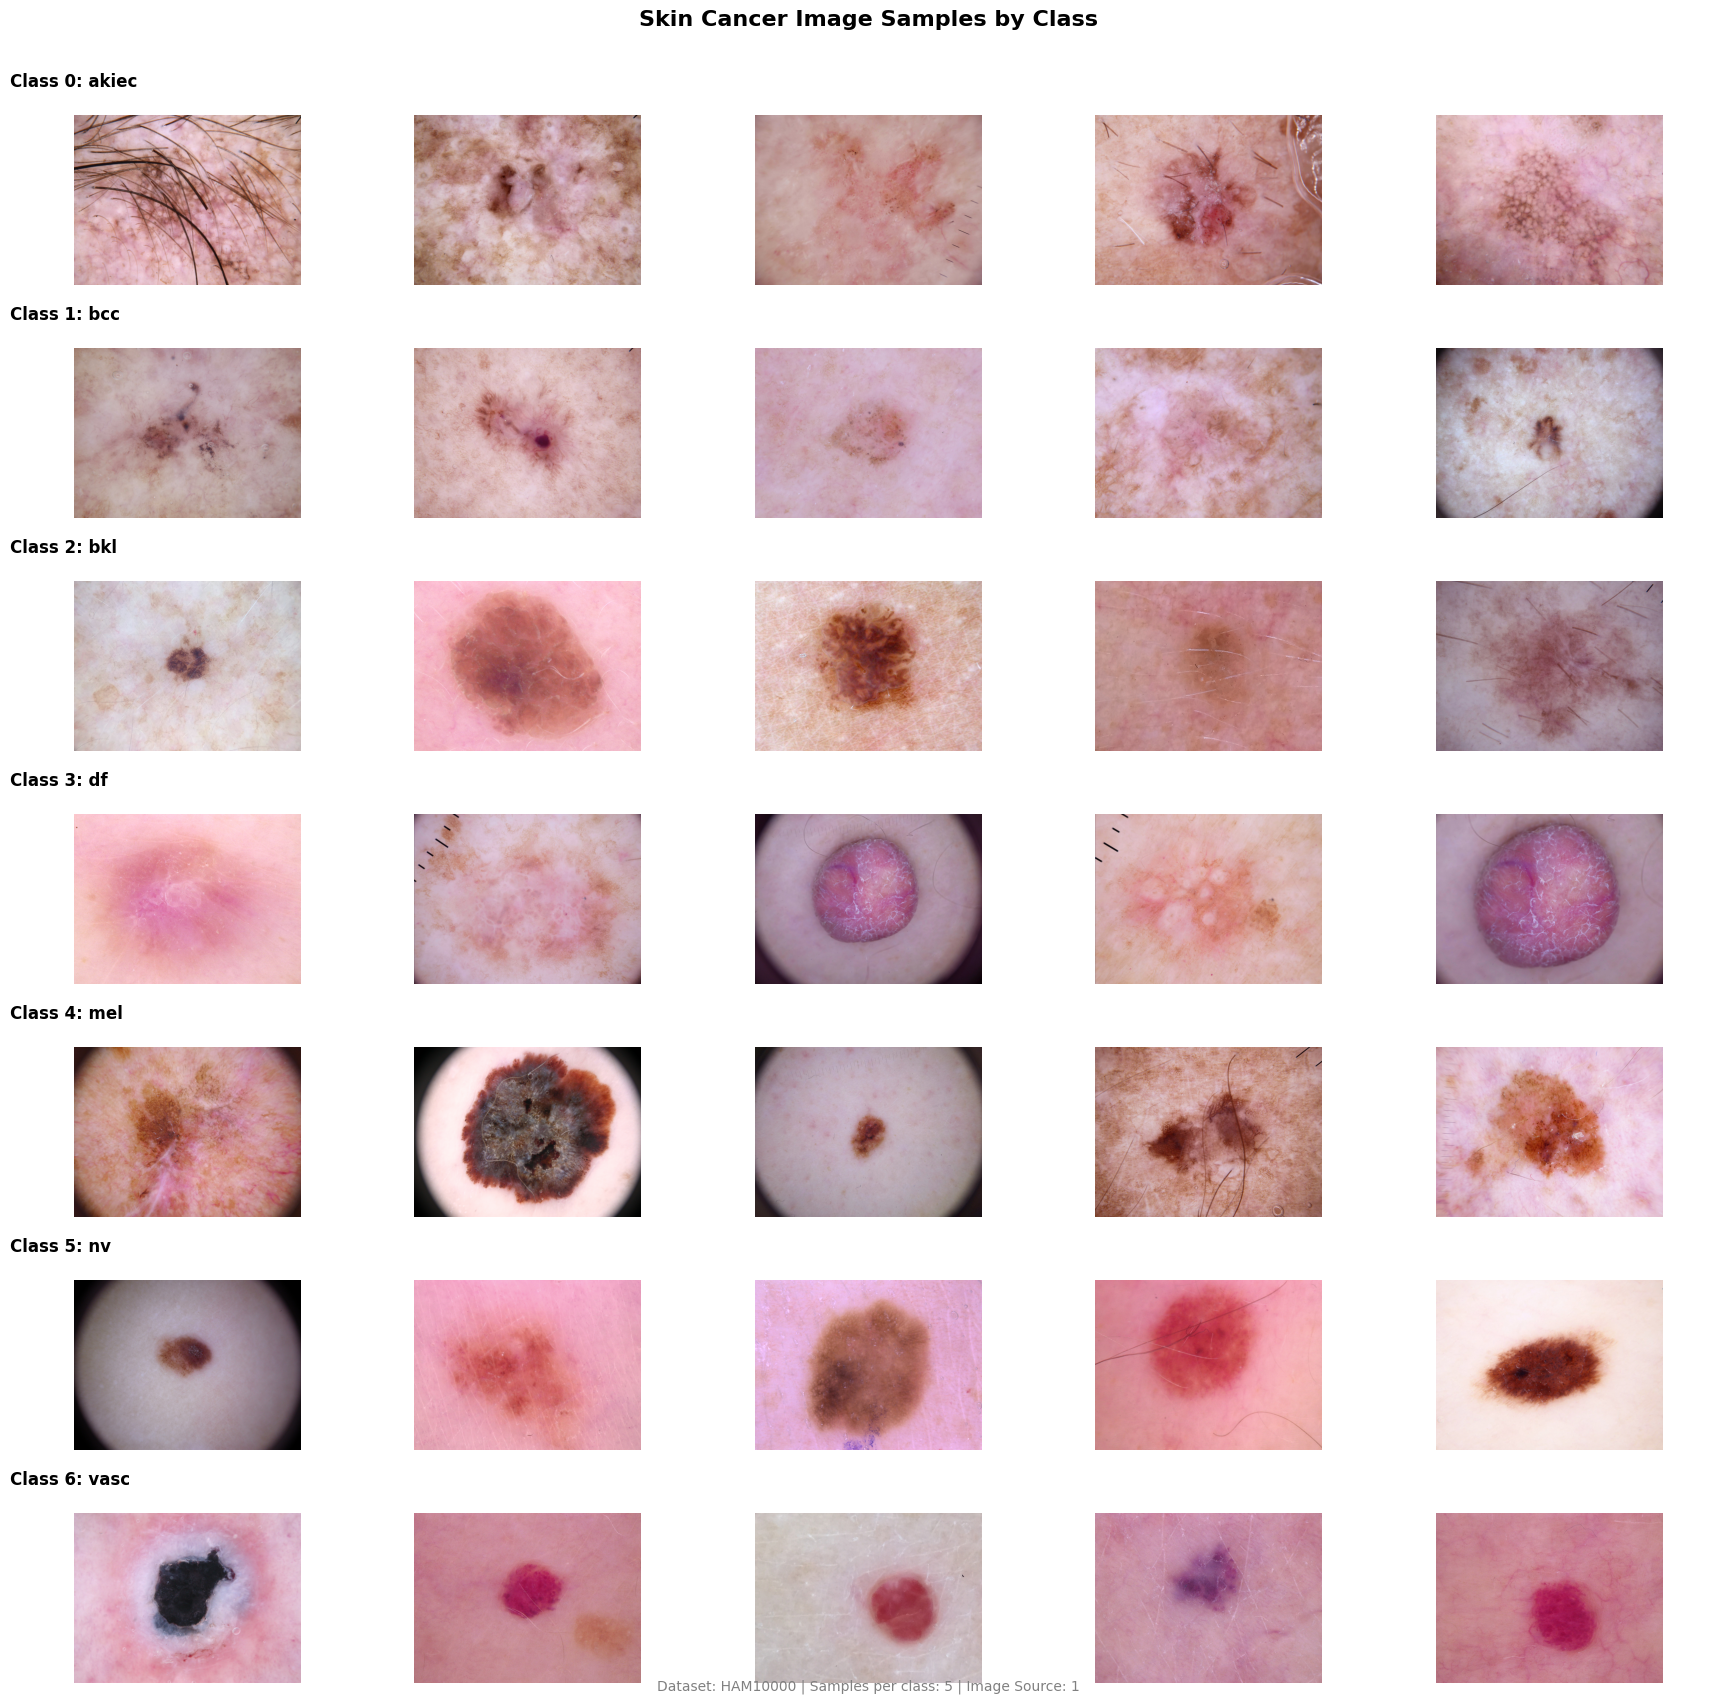

In [8]:
import matplotlib.pyplot as plt
import random
import cv2
import os
from textwrap import wrap

samples_per_class = 5
classes_to_display = min(7, len(encoder.classes_))
fig_width = 18
row_height = 2.5
title_fontsize = 16
class_fontsize = 12
footer_fontsize = 10


plt.figure(figsize=(fig_width, row_height * classes_to_display))
plt.suptitle("Skin Cancer Image Samples by Class",
             fontsize=title_fontsize,
             fontweight='bold',
             y=0.98)

class_dirs = sorted([d for d in os.scandir(train_images_dir) if d.is_dir()],
                   key=lambda x: int(x.name))

for class_idx, class_dir in enumerate(class_dirs[:classes_to_display]):
    class_num = int(class_dir.name)
    class_name = encoder.inverse_transform([class_num])[0]

    # Get all images for this class
    image_paths = [img.path for img in os.scandir(class_dir) if img.is_file() and img.name.endswith(('.jpg', '.png', '.jpeg'))]

    if not image_paths:
        continue

    # Randomly select samples
    sample_paths = random.sample(image_paths, min(samples_per_class, len(image_paths)))

    plt.subplot(classes_to_display, 1, class_idx + 1)
    plt.axis('off')
    plt.title(f"Class {class_num}: {class_name}",
              fontsize=class_fontsize,
              fontweight='bold',
              pad=20,
              loc='left')

    for sample_idx, img_path in enumerate(sample_paths):
        try:
            plt.subplot(classes_to_display, samples_per_class,
                       class_idx * samples_per_class + sample_idx + 1)

            img = cv2.imread(img_path)
            if img is None:
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            plt.axis('off')

        except Exception as e:
            print(f"Error processing {img_path}: {str(e)}")

plt.tight_layout(pad=3.0, h_pad=1.5, w_pad=0.5)
plt.subplots_adjust(top=0.92)

plt.figtext(0.5, 0.02,
            f"Dataset: HAM10000 | Samples per class: {samples_per_class} | Image Source: {os.path.basename(path)}",
            ha='center',
            fontsize=footer_fontsize,
            color='gray')

plt.show()

Data augmentation

In [9]:
# Data Augmentation Configuration
img_size = 256
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    shear_range=0.05,
    brightness_range=[0.9, 1.1],
    fill_mode='reflect',
    validation_split=0.2
)

# Validation/test generators (no augmentation, just normalization)
test_datagen = ImageDataGenerator(rescale=1./255)

random_seed = 42

# Training set with augmentation
print("\n\033[1mTraining Data:\033[0m")
train_generator = train_datagen.flow_from_directory(
    directory=train_images_dir,
    target_size=(img_size, img_size),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=random_seed
)

# Validation set (from training directory)
print("\n\033[1mValidation Data:\033[0m")
val_generator = train_datagen.flow_from_directory(
    directory=train_images_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=random_seed
)

# Independent test set (from validation directory)
print("\n\033[1mTest Data:\033[0m")
test_generator = test_datagen.flow_from_directory(
    directory=validation_images_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

print("\n\033[1mClass Distribution Report:\033[0m")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")





Training Data:
Found 7614 images belonging to 7 classes.

Validation Data:
Found 1900 images belonging to 7 classes.

Test Data:
Found 501 images belonging to 7 classes.

Class Distribution Report:
Training samples: 7614
Validation samples: 1900
Test samples: 501


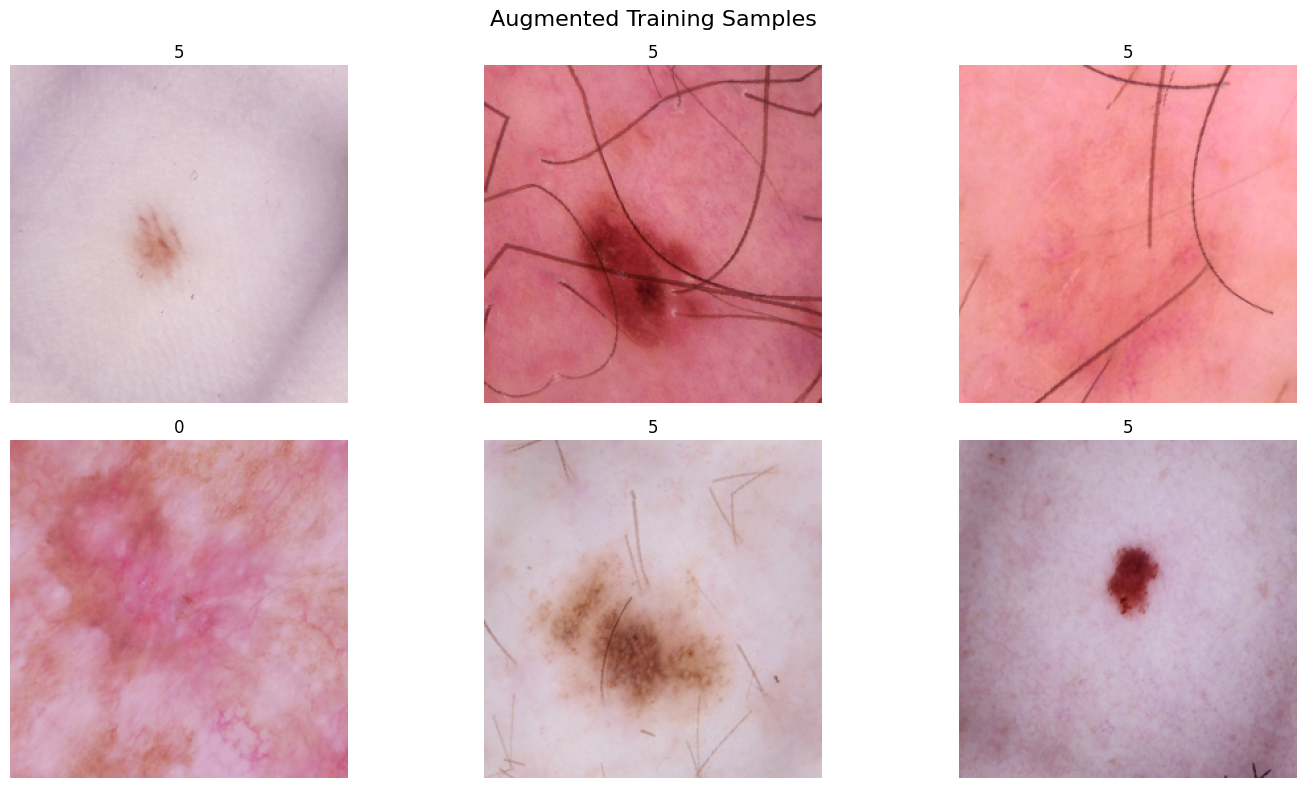

In [10]:
# Visualize augmented samples
def plot_augmented_samples(generator, n_samples=6):
    plt.figure(figsize=(15, 8))
    plt.suptitle("Augmented Training Samples", fontsize=16)
    for X_batch, y_batch in generator:
        for i in range(n_samples):
            ax = plt.subplot(2, 3, i+1)
            plt.imshow(X_batch[i])
            plt.axis('off')
            class_idx = np.argmax(y_batch[i])
            class_name = list(generator.class_indices.keys())[class_idx]
            plt.title(class_name, fontsize=12)
        break
    plt.tight_layout()
    plt.show()

plot_augmented_samples(train_generator)

Model training

In [43]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Optimized Model Architecture
model = Sequential()

# Input normalization
model.add(BatchNormalization(input_shape=(256, 256, 3)))

# Layer one - with regularization
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(0.01)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Layer two
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(0.01)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Layer three
model.add(Conv2D(256, (3,3), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(256, kernel_regularizer=l2(0.01)))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Dense(7))
model.add(Activation("softmax"))

model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_24          │ (None, 256, 256, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_47 (Activation)      │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_48 (Activation)      │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_49 (Activation)      │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 256)            │    67,109,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_50 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_51 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 7)              │           903 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 67,515,283 (257.55 MB)

 Trainable params: 67,514,509 (257.55 MB)

 Non-trainable params: 774 (3.02 KB)

In [44]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
import os

# Create a directory to save models
model_save_dir = "saved_models"
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)


In [45]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=os.path.join(model_save_dir, 'best_model.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
      )
]


In [46]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=50,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 796ms/step - accuracy: 0.3463 - loss: 13.5289
Epoch 1: val_accuracy improved from -inf to 0.67864, saving model to saved_models/best_model.h5


238/238 ━━━━━━━━━━━━━━━━━━━━ 276s 930ms/step - accuracy: 0.3467 - loss: 13.5136 - val_accuracy: 0.6786 - val_loss: 4.6730 - learning_rate: 0.0010
Epoch 2/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 769ms/step - accuracy: 0.5823 - loss: 4.1753
Epoch 2: val_accuracy did not improve from 0.67864
238/238 ━━━━━━━━━━━━━━━━━━━━ 188s 790ms/step - accuracy: 0.5824 - loss: 4.1740 - val_accuracy: 0.6687 - val_loss: 3.5790 - learning_rate: 0.0010
Epoch 3/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 768ms/step - accuracy: 0.6203 - loss: 3.7162
Epoch 3: val_accuracy did not improve from 0.67864
238/238 ━━━━━━━━━━━━━━━━━━━━ 188s 788ms/step - accuracy: 0.6203 - loss: 3.7147 - val_accuracy: 0.6687 - val_loss: 3.3417 - learning_rate: 0.0010
Epoch 4/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - accuracy: 0.6370 - loss: 3.8905
Epoch 4: val_accuracy did not improve from 0.67864
238/238 ━━━━━━━━━━━━━━━━━━━━ 183s 769ms/step - accuracy: 0.6370 - loss: 3.8907 - val_accuracy: 0.6687 - val_loss: 3.9868 - learning_rate: 0.0010
Ep


Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
238/238 ━━━━━━━━━━━━━━━━━━━━ 197s 826ms/step - accuracy: 0.6699 - loss: 5.3426 - val_accuracy: 0.6826 - val_loss: 5.3524 - learning_rate: 0.0010
Epoch 9/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 749ms/step - accuracy: 0.6713 - loss: 4.8189
Epoch 9: val_accuracy improved from 0.68263 to 0.68663, saving model to saved_models/best_model.h5


238/238 ━━━━━━━━━━━━━━━━━━━━ 198s 833ms/step - accuracy: 0.6712 - loss: 4.8171 - val_accuracy: 0.6866 - val_loss: 3.6392 - learning_rate: 2.0000e-04
Epoch 10/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 753ms/step - accuracy: 0.6717 - loss: 3.4553
Epoch 10: val_accuracy improved from 0.68663 to 0.69261, saving model to saved_models/best_model.h5


238/238 ━━━━━━━━━━━━━━━━━━━━ 201s 844ms/step - accuracy: 0.6717 - loss: 3.4546 - val_accuracy: 0.6926 - val_loss: 2.9015 - learning_rate: 2.0000e-04
Epoch 11/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 746ms/step - accuracy: 0.6636 - loss: 2.8379
Epoch 11: val_accuracy improved from 0.69261 to 0.69461, saving model to saved_models/best_model.h5


238/238 ━━━━━━━━━━━━━━━━━━━━ 205s 859ms/step - accuracy: 0.6636 - loss: 2.8374 - val_accuracy: 0.6946 - val_loss: 2.5160 - learning_rate: 2.0000e-04
Epoch 12/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 734ms/step - accuracy: 0.6658 - loss: 2.4243
Epoch 12: val_accuracy did not improve from 0.69461
238/238 ━━━━━━━━━━━━━━━━━━━━ 179s 751ms/step - accuracy: 0.6658 - loss: 2.4240 - val_accuracy: 0.6946 - val_loss: 2.1301 - learning_rate: 2.0000e-04
Epoch 13/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - accuracy: 0.6660 - loss: 2.1142
Epoch 13: val_accuracy did not improve from 0.69461
238/238 ━━━━━━━━━━━━━━━━━━━━ 184s 773ms/step - accuracy: 0.6660 - loss: 2.1140 - val_accuracy: 0.6946 - val_loss: 1.8906 - learning_rate: 2.0000e-04
Epoch 14/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 761ms/step - accuracy: 0.6691 - loss: 1.9150
Epoch 14: val_accuracy did not improve from 0.69461
238/238 ━━━━━━━━━━━━━━━━━━━━ 187s 786ms/step - accuracy: 0.6691 - loss: 1.9149 - val_accuracy: 0.6906 - val_loss: 1.7715 - learnin

238/238 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - accuracy: 0.6715 - loss: 1.3582 - val_accuracy: 0.6966 - val_loss: 1.2217 - learning_rate: 2.0000e-04
Epoch 21/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 734ms/step - accuracy: 0.6694 - loss: 1.2930
Epoch 21: val_accuracy did not improve from 0.69661
238/238 ━━━━━━━━━━━━━━━━━━━━ 180s 756ms/step - accuracy: 0.6694 - loss: 1.2930 - val_accuracy: 0.6946 - val_loss: 1.2120 - learning_rate: 2.0000e-04
Epoch 22/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 759ms/step - accuracy: 0.6774 - loss: 1.2490
Epoch 22: val_accuracy did not improve from 0.69661
238/238 ━━━━━━━━━━━━━━━━━━━━ 186s 781ms/step - accuracy: 0.6774 - loss: 1.2490 - val_accuracy: 0.6906 - val_loss: 1.1822 - learning_rate: 2.0000e-04
Epoch 23/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 740ms/step - accuracy: 0.6712 - loss: 1.2330
Epoch 23: val_accuracy did not improve from 0.69661
238/238 ━━━━━━━━━━━━━━━━━━━━ 181s 762ms/step - accuracy: 0.6712 - loss: 1.2329 - val_accuracy: 0.6946 - val_loss: 1.1257 - learning_r

238/238 ━━━━━━━━━━━━━━━━━━━━ 222s 932ms/step - accuracy: 0.6764 - loss: 1.1737 - val_accuracy: 0.7166 - val_loss: 1.1679 - learning_rate: 2.0000e-04
Epoch 26/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 751ms/step - accuracy: 0.6646 - loss: 1.1949
Epoch 26: val_accuracy did not improve from 0.71657
238/238 ━━━━━━━━━━━━━━━━━━━━ 223s 765ms/step - accuracy: 0.6646 - loss: 1.1948 - val_accuracy: 0.6946 - val_loss: 1.1491 - learning_rate: 2.0000e-04
Epoch 27/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - accuracy: 0.6742 - loss: 1.2257
Epoch 27: val_accuracy did not improve from 0.71657
238/238 ━━━━━━━━━━━━━━━━━━━━ 181s 760ms/step - accuracy: 0.6742 - loss: 1.2256 - val_accuracy: 0.6926 - val_loss: 1.1354 - learning_rate: 2.0000e-04
Epoch 28/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 749ms/step - accuracy: 0.6774 - loss: 1.1633
Epoch 28: val_accuracy did not improve from 0.71657
238/238 ━━━━━━━━━━━━━━━━━━━━ 182s 763ms/step - accuracy: 0.6774 - loss: 1.1633 - val_accuracy: 0.7006 - val_loss: 1.2090 - learnin

238/238 ━━━━━━━━━━━━━━━━━━━━ 218s 917ms/step - accuracy: 0.6730 - loss: 1.1316 - val_accuracy: 0.7186 - val_loss: 1.0773 - learning_rate: 2.0000e-04
Epoch 32/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 734ms/step - accuracy: 0.6763 - loss: 1.1004
Epoch 32: val_accuracy did not improve from 0.71856
238/238 ━━━━━━━━━━━━━━━━━━━━ 181s 760ms/step - accuracy: 0.6763 - loss: 1.1004 - val_accuracy: 0.6946 - val_loss: 1.0211 - learning_rate: 2.0000e-04
Epoch 33/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 745ms/step - accuracy: 0.6733 - loss: 1.1071
Epoch 33: val_accuracy did not improve from 0.71856
238/238 ━━━━━━━━━━━━━━━━━━━━ 182s 765ms/step - accuracy: 0.6733 - loss: 1.1071 - val_accuracy: 0.6906 - val_loss: 0.9566 - learning_rate: 2.0000e-04
Epoch 34/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 745ms/step - accuracy: 0.6839 - loss: 1.0724
Epoch 34: val_accuracy did not improve from 0.71856
238/238 ━━━━━━━━━━━━━━━━━━━━ 183s 767ms/step - accuracy: 0.6839 - loss: 1.0723 - val_accuracy: 0.7086 - val_loss: 0.9725 - learnin

238/238 ━━━━━━━━━━━━━━━━━━━━ 218s 914ms/step - accuracy: 0.6904 - loss: 0.9802 - val_accuracy: 0.7345 - val_loss: 0.8595 - learning_rate: 4.0000e-05
Epoch 44/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 736ms/step - accuracy: 0.6827 - loss: 0.9705
Epoch 44: val_accuracy did not improve from 0.73453
238/238 ━━━━━━━━━━━━━━━━━━━━ 181s 760ms/step - accuracy: 0.6827 - loss: 0.9704 - val_accuracy: 0.7325 - val_loss: 0.8394 - learning_rate: 4.0000e-05
Epoch 45/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 740ms/step - accuracy: 0.6912 - loss: 0.9283
Epoch 45: val_accuracy did not improve from 0.73453
238/238 ━━━━━━━━━━━━━━━━━━━━ 201s 756ms/step - accuracy: 0.6912 - loss: 0.9283 - val_accuracy: 0.7345 - val_loss: 0.8244 - learning_rate: 4.0000e-05
Epoch 46/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - accuracy: 0.6851 - loss: 0.9505
Epoch 46: val_accuracy improved from 0.73453 to 0.74251, saving model to saved_models/best_model.h5


238/238 ━━━━━━━━━━━━━━━━━━━━ 210s 883ms/step - accuracy: 0.6852 - loss: 0.9504 - val_accuracy: 0.7425 - val_loss: 0.8108 - learning_rate: 4.0000e-05
Epoch 47/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 732ms/step - accuracy: 0.6906 - loss: 0.9095
Epoch 47: val_accuracy did not improve from 0.74251
238/238 ━━━━━━━━━━━━━━━━━━━━ 178s 746ms/step - accuracy: 0.6906 - loss: 0.9095 - val_accuracy: 0.7305 - val_loss: 0.8159 - learning_rate: 4.0000e-05
Epoch 48/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 737ms/step - accuracy: 0.6969 - loss: 0.9125
Epoch 48: val_accuracy did not improve from 0.74251
238/238 ━━━━━━━━━━━━━━━━━━━━ 181s 758ms/step - accuracy: 0.6969 - loss: 0.9125 - val_accuracy: 0.7305 - val_loss: 0.7999 - learning_rate: 4.0000e-05
Epoch 49/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 733ms/step - accuracy: 0.6927 - loss: 0.9082
Epoch 49: val_accuracy did not improve from 0.74251
238/238 ━━━━━━━━━━━━━━━━━━━━ 179s 753ms/step - accuracy: 0.6927 - loss: 0.9082 - val_accuracy: 0.7265 - val_loss: 0.7965 - learnin

In [47]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nFinal Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Final Test Loss: {test_loss:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 215ms/step - accuracy: 0.5183 - loss: 1.2257

Final Test Accuracy: 72.65%
Final Test Loss: 0.7965


In [51]:
model_save_dir = "saved_models"
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

print("\nSaving models in different formats...")

keras_save_path = os.path.join(model_save_dir, 'model.keras')
model.save(keras_save_path)
print("Saved Keras model")

h5_save_path = os.path.join(model_save_dir, 'model.h5')
model.save(h5_save_path)
print("Saved H5 model")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

tflite_save_path = os.path.join(model_save_dir, 'model.tflite')
with open(tflite_save_path, 'wb') as f:
    f.write(tflite_model)
print("Saved TFLite model")

weights_path = os.path.join(model_save_dir, 'model.weights.h5')
model.save_weights(weights_path)
print("Saved model weights")

class_mapping = {v: k for k, v in train_generator.class_indices.items()}
import json
with open(os.path.join(model_save_dir, 'class_mapping.json'), 'w') as f:
    json.dump(class_mapping, f)
print("Saved class mapping")


Saving models in different formats...


Saved Keras model
Saved H5 model
Saved artifact at '/tmp/tmpwey5l0s4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_1751')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  136460742686096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136460742686672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136460742688016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136460742686480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136460742674000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136460742676304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136460742687056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136460742672464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136460742676496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136460742678992: TensorSpec(shape=(), dtype=tf

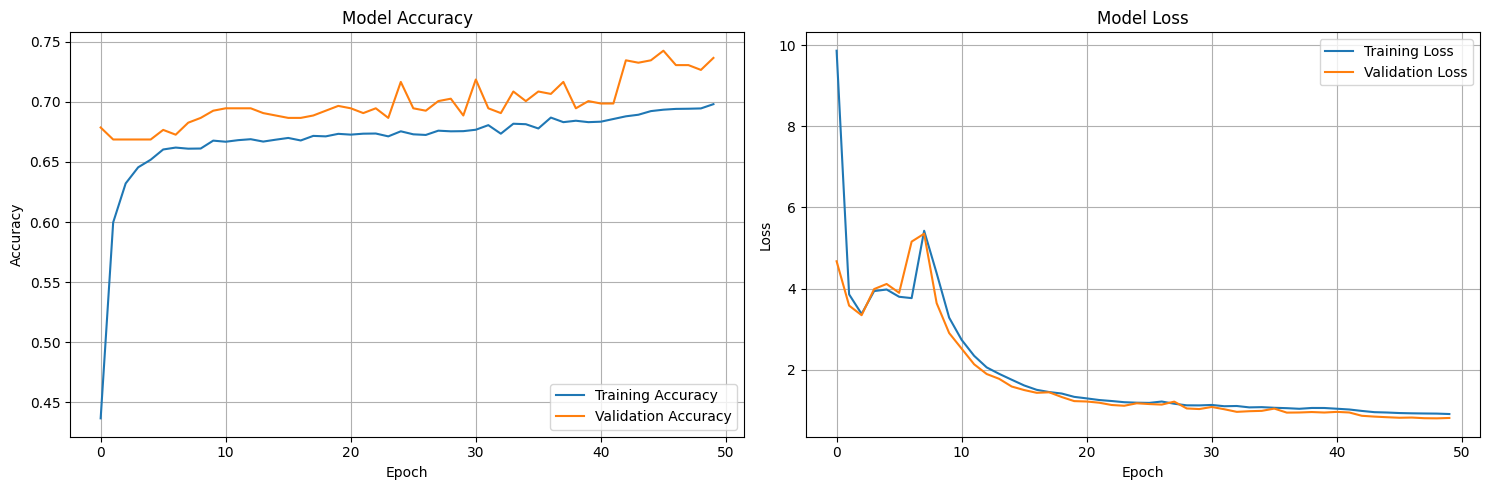

In [52]:
# Plot detailed training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 259ms/step


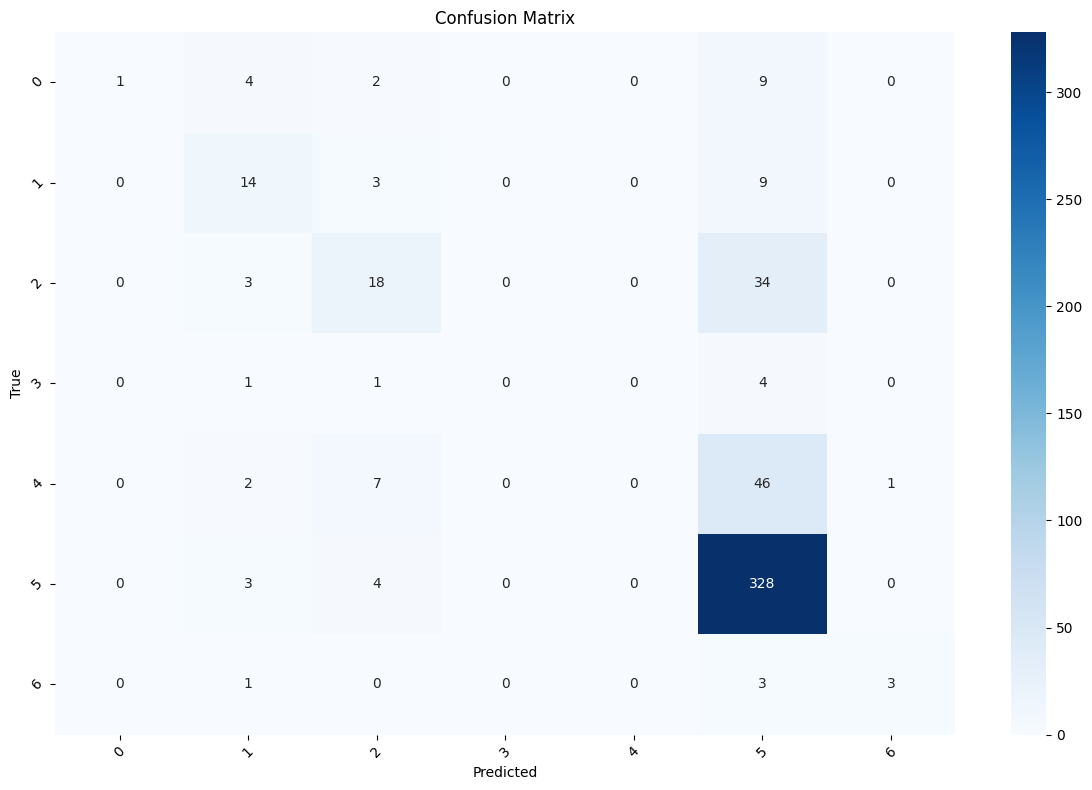


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.06      0.12        16
           1       0.50      0.54      0.52        26
           2       0.51      0.33      0.40        55
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00        56
           5       0.76      0.98      0.85       335
           6       0.75      0.43      0.55         7

    accuracy                           0.73       501
   macro avg       0.50      0.33      0.35       501
weighted avg       0.63      0.73      0.65       501



In [53]:
# Generate confusion matrix
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Plot confusion matrix
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_mapping.values(),
            yticklabels=class_mapping.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes,
                          target_names=class_mapping.values()))